# **Chapter 9 – Up and running with TensorFlow**

## The evaluation in instant traditionally

In [2]:
x = 1
y = 2

In [3]:
f = x*x*y + y + 2
f

6

# Setup

In [4]:
# Check the tensorflow version

import tensorflow
print(tensorflow.__version__)

/usr/local/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.6.0


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [5]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Creating and running a graph

In [6]:
import tensorflow as tf

reset_graph()

x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [7]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [8]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


In [9]:
# Better way
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

result

42

In [10]:
# Another better way

init = tf.global_variables_initializer() # prepare an init node

with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()

result

42

# Managing graphs

In [11]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

print(tf.get_default_graph())

In [12]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


In [13]:
# To reset the default group

reset_graph()

# Lifecycle of a Node Value

In [14]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  # 10
    print(z.eval())  # 15

10
15


In [15]:
# Run previous code efficiently

with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


# Linear Regression

### Using sklearn



In [16]:
import numpy as np

X = np.array([[1,5/3],[1, 1/9]])
y = np.array([[12/3],[21/9]])
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
theta_best

array([[2.21428571],
       [1.07142857]])

## Using the Normal Equation

In [17]:
# Calculate theta using normal equation in TensorFlow
# We will use housing dataset of end-to-end project

import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
theta_value

array([[-3.7185181e+01],
       [ 4.3633747e-01],
       [ 9.3952334e-03],
       [-1.0711310e-01],
       [ 6.4479220e-01],
       [-4.0338000e-06],
       [-3.7813708e-03],
       [-4.2348403e-01],
       [-4.3721911e-01]], dtype=float32)

In [18]:
# Compare it with pure NumPy
# Calculate theta using normal equation in NumPy

X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


In [19]:
# Compare it with pure NumPy
# Calculate theta using Scikit-Learn

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


## Using Batch Gradient Descent

In [20]:
# Step 1- Normalize the feature vector list using Scikit-Learn
# Gradient Descent requires scaling the feature vectors first
# We could do this using TF, but let's just use Scikit-Learn for now.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### Manually computing the gradients

In [21]:
# Step 2- Manually computing the gradient
# The Code is self-explanatory, except for a few new elements

'''

1. random_uniform() - The random_uniform() function creates a node in the graph that will generate a tensor containing
random values, given its shape and value range, much like NumPy’s rand() function.

2. assign() - The assign() function creates a node that will assign a new value to a variable. In this case, it
implements the Batch Gradient Descent step θ(next step) = θ – η∇θMSE(θ).

3. The main loop executes the training step over and over again (n_epochs times), and every 100 iterations it prints 
out the current Mean Squared Error (mse). We can see the MSE go down at every iteration

'''

reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()
best_theta

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.71450067
Epoch 200 MSE = 0.5667049
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.53650916
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474


array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770885],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

### Using autodiff

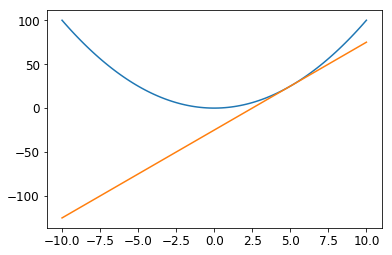

In [22]:
# Let us understand the differentiation
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Generate x
x = np.linspace(-10, 10, 100)
# Compute y
y = x*x

# plot the parabola
plt.plot(x, y)

#Lets draw a tangent at x0 = 5
x0 = 5
m = slope = 2*x0 # d(x^2)/dx

y1 = m*x-25
plt.plot(x, y1)

In [23]:
# The above method was possible only for the cases where computing differential was easy. We can use autodiff.
# Lets try. Now, lets compute the 
import tensorflow as tf
tf.reset_default_graph()
x = tf.constant(5.0)
y = tf.square(x)
z = tf.gradients(y, x)
with tf.Session() as s:
    print(z[0].eval())

10.0


In [24]:
# Same as above except for the `gradients = ...` line:
# Compute gradients using autodiff

reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [25]:
gradients = tf.gradients(mse, [theta])[0]

In [26]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


In [27]:
# Find the partial derivatives of the following function with regards to `a` and `b`

def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [28]:
my_func(0.2, 0.3)

-0.21253923284754914

In [29]:
reset_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

Let's compute the function at $a=0.2$ and $b=0.3$, and the partial derivatives at that point with regards to $a$ and with regards to $b$:

In [30]:
with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388494, 0.19671395]


### Using a `GradientDescentOptimizer`

In [31]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [32]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [33]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### Using a momentum optimizer

In [34]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [35]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [36]:
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [37]:
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Best theta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875337]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# Feeding data to the training algorithm

## Placeholder nodes

In [38]:
reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


## Mini-batch Gradient Descent

In [39]:
#Let's implement mini-batch using placeholder nodes

reset_graph()

learning_rate = 0.01

# Let's make X and y as placeholder nodes

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")


theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [40]:
# Define the batch size and compute the total number of batches
# Define function to fetch batch

n_epochs = 10

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index) 
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

In [44]:
fetch_batch(1, 1, 1)

(array([[ 1.        , -0.94235915,  1.06160074, -0.45870257,  0.04425393,
         -0.19380963, -0.1004992 ,  1.03382082, -1.34280914]]),
 array([[2.267]]))

In [41]:
# This is execution phase
# Fetch the mini-batches one by one then provide the value of x and y via the feed_dict parameter

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

best_theta

array([[ 0.36894485],
       [ 0.07636866],
       [ 0.6792061 ],
       [-0.11886713],
       [ 0.84787256],
       [ 0.6232598 ],
       [ 0.19132051],
       [ 0.27507773],
       [-0.52806485]], dtype=float32)

# Saving and restoring a model

In [85]:
# Let's save a model
# Code for GradientDescentOptimizer

reset_graph()

n_epochs = 1000                                                                       
learning_rate = 0.01                                                                  

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")           
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      
error = y_pred - y                                                                    
mse = tf.reduce_mean(tf.square(error), name="mse")                                    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            
training_op = optimizer.minimize(mse)                                                

init = tf.global_variables_initializer()
saver = tf.train.Saver() # Create a Saver node

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                            
            save_path = saver.save(sess, "/tmp/my_model.ckpt") # Save checkpoint during training
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt") # Save model after training

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474


In [77]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [86]:
# Restore model

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [50]:
np.allclose?

In [80]:
# Check if restored theta is same as the saved theta

np.allclose(best_theta, best_theta_restored)

True

In [52]:
tf.train.Saver?

By default a Saver saves and restores all variables under their own name, but if you need more control, you can specify which variables to save or restore, and what names to use. For example, the following
Saver will save or restore only the theta variable under the name weights:

In [74]:
# If we want to have a saver that loads and restores `theta` with a different name, such as `"weights"`
saver = tf.train.Saver({"weights": theta})

By default the saver also saves the graph structure itself in a second file with the extension `.meta`. You can use the function `tf.train.import_meta_graph()` to restore the graph structure. This function loads the graph into the default graph and returns a `Saver` that can then be used to restore the graph state (i.e., the variable values):

In [75]:
reset_graph()
# notice that we start with an empty graph.

saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")  # this loads the graph structure
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")  # this restores the graph's state
    best_theta_restored = theta.eval() 

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [152]:
np.allclose(best_theta, best_theta_restored)

True

This means that you can import a pretrained model without having to have the corresponding Python code to build the graph. This is very handy when you keep tweaking and saving your model: you can load a previously saved model without having to search for the version of the code that built it.

# Visualizing the graph
## inside Jupyter

In [40]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [63]:
show_graph(tf.get_default_graph())

## Using TensorBoard

In [42]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [43]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [44]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [45]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [48]:
with tf.Session() as sess:                                                        
    sess.run(init)                                                               

    for epoch in range(n_epochs):                                                 
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                   

In [49]:
file_writer.close()

In [50]:
best_theta

array([[ 0.36894485],
       [ 0.07636866],
       [ 0.6792061 ],
       [-0.11886713],
       [ 0.84787256],
       [ 0.6232598 ],
       [ 0.19132051],
       [ 0.27507773],
       [-0.52806485]], dtype=float32)

# Name scopes

In [51]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [52]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [53]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [54]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 0.36894485]
 [ 0.07636866]
 [ 0.6792061 ]
 [-0.11886713]
 [ 0.84787256]
 [ 0.6232598 ]
 [ 0.19132051]
 [ 0.27507773]
 [-0.52806485]]


In [55]:
print(error.op.name)

loss/sub


In [56]:
print(mse.op.name)

loss/mse


In [57]:
reset_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# Modularity

An ugly flat code:

In [58]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

Much better, using a function to build the ReLUs:

In [59]:
reset_graph()

def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [60]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

Even better using name scopes:

In [61]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    # not shown
        b = tf.Variable(0.0, name="bias")                             # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                      # not shown
        return tf.maximum(z, 0., name="max")                          # not shown

In [62]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

## Sharing Variables

Sharing a `threshold` variable the classic way, by defining it outside of the `relu()` function then passing it as a parameter:

In [ ]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [ ]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, relu.threshold, name="max")

In [ ]:
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [ ]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [ ]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [ ]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [ ]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [ ]:
file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
file_writer.close()

In [ ]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
file_writer.close()

In [ ]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [ ]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

# Extra material

In [ ]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")

with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

The first `variable_scope()` block first creates the shared variable `x0`, named `my_scope/x`. For all operations other than shared variables (including non-shared variables), the variable scope acts like a regular name scope, which is why the two variables `x1` and `x2` have a name with a prefix `my_scope/`. Note however that TensorFlow makes their names unique by adding an index: `my_scope/x_1` and `my_scope/x_2`.

The second `variable_scope()` block reuses the shared variables in scope `my_scope`, which is why `x0 is x3`. Once again, for all operations other than shared variables it acts as a named scope, and since it's a separate block from the first one, the name of the scope is made unique by TensorFlow (`my_scope_1`) and thus the variable `x4` is named `my_scope_1/x`.

The third block shows another way to get a handle on the shared variable `my_scope/x` by creating a `variable_scope()` at the root scope (whose name is an empty string), then calling `get_variable()` with the full name of the shared variable (i.e. `"my_scope/x"`).

## Strings

In [ ]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

## Implementing a Home-Made Computation Graph

In [ ]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
    def evaluate(self):
        return self.value
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() + self.b.evaluate()
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        return self.a.evaluate() * self.b.evaluate()
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2
print("f(x,y) =", f)
print("f(3,4) =", f.evaluate())

## Computing gradients
### Mathematical differentiation

In [ ]:
df_dx = Mul(Const(2), Mul(x, y))  # df/dx = 2xy
df_dy = Add(Mul(x, x), Const(1))  # df/dy = x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

### Numerical differentiation

In [ ]:
def gradients(func, vars_list, eps=0.0001):
    partial_derivatives = []
    base_func_eval = func.evaluate()
    for var in vars_list:
        original_value = var.value
        var.value = var.value + eps
        tweaked_func_eval = func.evaluate()
        var.value = original_value
        derivative = (tweaked_func_eval - base_func_eval) / eps
        partial_derivatives.append(derivative)
    return partial_derivatives

df_dx, df_dy = gradients(f, [x, y])
print("df/dx(3,4) =", df_dx)
print("df/dy(3,4) =", df_dy)

### Symbolic differentiation

In [ ]:
Const.derive = lambda self, var: Const(0)
Var.derive = lambda self, var: Const(1) if self is var else Const(0)
Add.derive = lambda self, var: Add(self.a.derive(var), self.b.derive(var))
Mul.derive = lambda self, var: Add(Mul(self.a, self.b.derive(var)), Mul(self.a.derive(var), self.b))

x = Var(3.0, name="x")
y = Var(4.0, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

df_dx = f.derive(x)  # 2xy
df_dy = f.derive(y)  # x² + 1
print("df/dx(3,4) =", df_dx.evaluate())
print("df/dy(3,4) =", df_dy.evaluate())

### Automatic differentiation (autodiff) – forward mode

In [ ]:
class DualNumber(object):
    def __init__(self, value=0.0, eps=0.0):
        self.value = value
        self.eps = eps
    def __add__(self, b):
        return DualNumber(self.value + self.to_dual(b).value,
                          self.eps + self.to_dual(b).eps)
    def __radd__(self, a):
        return self.to_dual(a).__add__(self)
    def __mul__(self, b):
        return DualNumber(self.value * self.to_dual(b).value,
                          self.eps * self.to_dual(b).value + self.value * self.to_dual(b).eps)
    def __rmul__(self, a):
        return self.to_dual(a).__mul__(self)
    def __str__(self):
        if self.eps:
            return "{:.1f} + {:.1f}ε".format(self.value, self.eps)
        else:
            return "{:.1f}".format(self.value)
    def __repr__(self):
        return str(self)
    @classmethod
    def to_dual(cls, n):
        if hasattr(n, "value"):
            return n
        else:
            return cls(n)

$3 + (3 + 4 \epsilon) = 6 + 4\epsilon$

In [ ]:
3 + DualNumber(3, 4)

$(3 + 4ε)\times(5 + 7ε) = 3 \times 5 + 3 \times 7ε + 4ε \times 5 + 4ε \times 7ε = 15 + 21ε + 20ε + 28ε^2 = 15 + 41ε + 28 \times 0 = 15 + 41ε$

In [ ]:
DualNumber(3, 4) * DualNumber(5, 7)

In [ ]:
x.value = DualNumber(3.0)
y.value = DualNumber(4.0)

f.evaluate()

In [ ]:
x.value = DualNumber(3.0, 1.0)  # 3 + ε
y.value = DualNumber(4.0)       # 4

df_dx = f.evaluate().eps

x.value = DualNumber(3.0)       # 3
y.value = DualNumber(4.0, 1.0)  # 4 + ε

df_dy = f.evaluate().eps

In [ ]:
df_dx

In [ ]:
df_dy

### Autodiff – Reverse mode

In [ ]:
class Const(object):
    def __init__(self, value):
        self.value = value
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        pass
    def __str__(self):
        return str(self.value)

class Var(object):
    def __init__(self, init_value, name):
        self.value = init_value
        self.name = name
        self.gradient = 0
    def evaluate(self):
        return self.value
    def backpropagate(self, gradient):
        self.gradient += gradient
    def __str__(self):
        return self.name

class BinaryOperator(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b

class Add(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() + self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient)
        self.b.backpropagate(gradient)
    def __str__(self):
        return "{} + {}".format(self.a, self.b)

class Mul(BinaryOperator):
    def evaluate(self):
        self.value = self.a.evaluate() * self.b.evaluate()
        return self.value
    def backpropagate(self, gradient):
        self.a.backpropagate(gradient * self.b.value)
        self.b.backpropagate(gradient * self.a.value)
    def __str__(self):
        return "({}) * ({})".format(self.a, self.b)

x = Var(3, name="x")
y = Var(4, name="y")
f = Add(Mul(Mul(x, x), y), Add(y, Const(2))) # f(x,y) = x²y + y + 2

result = f.evaluate()
f.backpropagate(1.0)

print("f(x,y) =", f)
print("f(3,4) =", result)
print("df_dx =", x.gradient)
print("df_dy =", y.gradient)

### Autodiff – reverse mode (using TensorFlow)

In [ ]:
reset_graph()

x = tf.Variable(3., name="x")
y = tf.Variable(4., name="y")
f = x*x*y + y + 2

gradients = tf.gradients(f, [x, y])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    f_val, gradients_val = sess.run([f, gradients])

f_val, gradients_val

The `reciprocal()` function from SciPy's `stats` module returns a random distribution that is commonly used when you have no idea of the optimal scale of a hyperparameter. See the exercise solutions for chapter 2 for more details. 